In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.stats import zscore
from sklearn.metrics import log_loss

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')

In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')

In [5]:
X = train.drop(columns=['Status'])
y = train['Status']

In [6]:
#  numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
# categorical_features = X.select_dtypes(include=['object']).columns

In [7]:
# # numeric_features.drop(['id','Stage','Cholesterol'], inplace = True)
# print(numeric_features)
# print(categorical_features)

In [8]:
numeric_features = [ 'N_Days', 'Age', 'Bilirubin', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin','Stage']
categorical_features = ['Sex','Ascites','Hepatomegaly','Spiders','Edema']

In [9]:
X.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0


In [10]:
y_c = y.map({'C': 0, 'D': 2, 'CL': 1})

In [11]:
print(y_c)

0       2
1       0
2       2
3       0
4       0
       ..
7900    0
7901    0
7902    2
7903    2
7904    0
Name: Status, Length: 7905, dtype: int64


In [12]:
X = train
X_numeric = X[numeric_features]
result_df_num = pd.concat([X_numeric, y_c], ignore_index=True)
X_cate = X[categorical_features]
result_df_cat = pd.concat([X_cate, y], ignore_index=True)

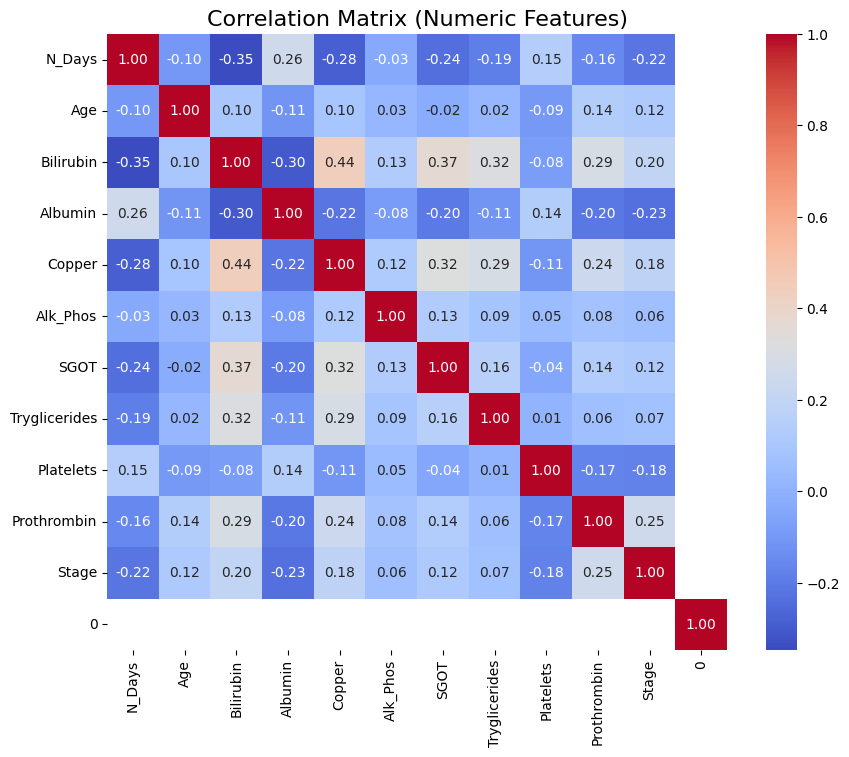

In [13]:
correlation_matrix_numeric = result_df_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Numeric Features)', fontsize=16)
plt.show()

In [14]:
# correlation_matrix_categorical = pd.get_dummies(result_df_cat, drop_first=True).corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix_categorical, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix (Categorical Features)', fontsize=16)
# plt.show()

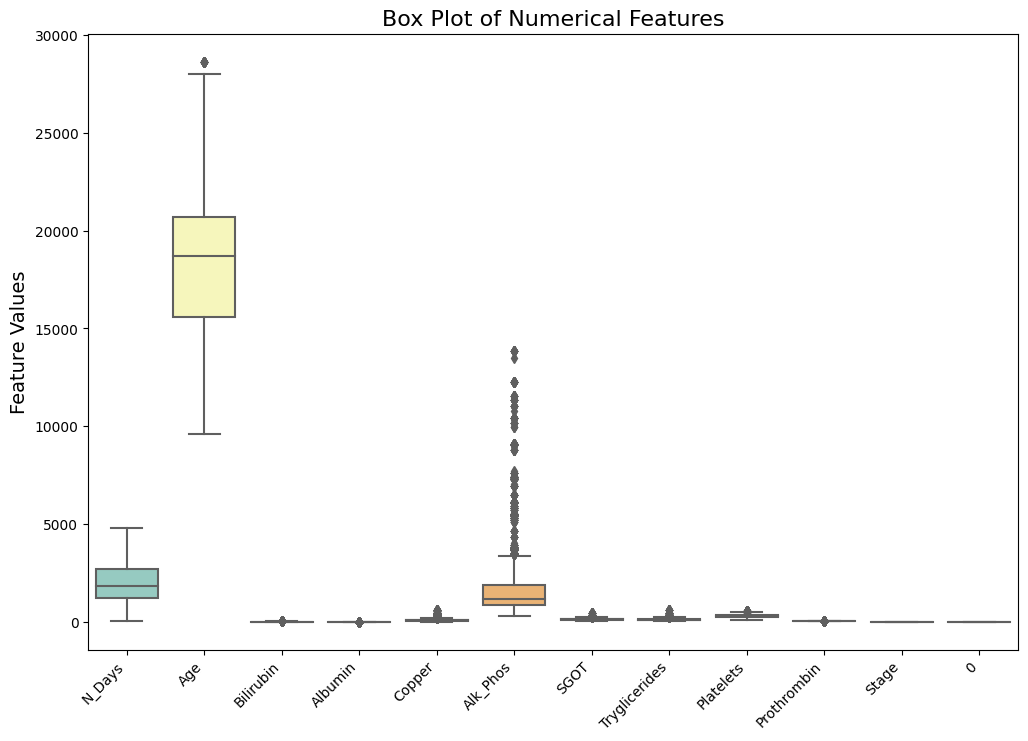

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=result_df_num, palette="Set3")
plt.title('Box Plot of Numerical Features', fontsize=16)
plt.ylabel('Feature Values', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [16]:
def remove_outliers_iqr(data_frame, threshold=1.5):
    data_frame_cleaned = pd.DataFrame()

    # Select numeric columns for outlier removal
    numeric_columns = data_frame.select_dtypes(include=['number']).columns

    for column in numeric_columns:
        feature_values = data_frame[column]
        Q1 = feature_values.quantile(0.25)
        Q3 = feature_values.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Keep only the data points within the specified bounds
        data_frame_cleaned[column] = feature_values[(feature_values >= lower_bound) & (feature_values <= upper_bound)]

    # Add remaining categorical columns
    categorical_columns = data_frame.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        data_frame_cleaned[column] = data_frame[column]

    return data_frame_cleaned


In [17]:
df_cleaned = remove_outliers_iqr(X)
print(df_cleaned.columns)

Index(['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',
       'Status'],
      dtype='object')


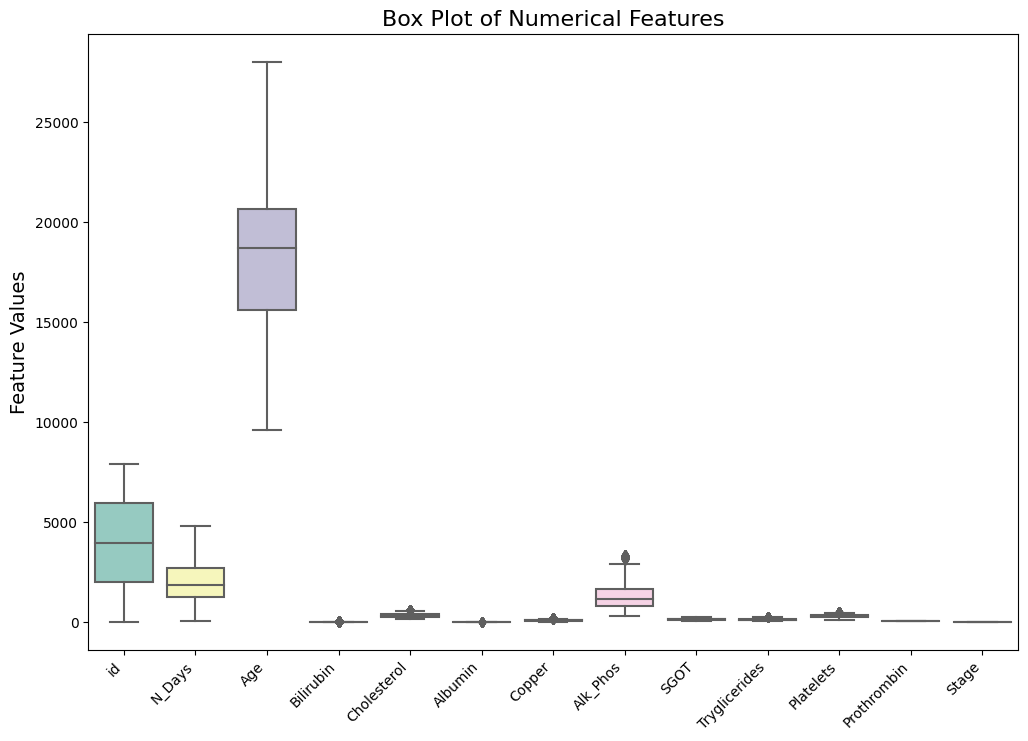

In [18]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned, palette="Set3")
plt.title('Box Plot of Numerical Features', fontsize=16)
plt.ylabel('Feature Values', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [19]:
# correlation_matrix_numeric = df_cleaned.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix (Numeric Features)', fontsize=16)
# plt.show()

In [20]:
# plt.figure(figsize=(12, 8))
# sns.boxplot(data=correlation_matrix_categorical, palette="Set3")
# plt.title('Box Plot of Numerical Features', fontsize=16)
# plt.ylabel('Feature Values', fontsize=14)
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# plt.show()

In [21]:
# df_cleaned_2 = remove_outliers_iqr_per_column(correlation_matrix_categorical)

In [22]:
# print(df_cleaned_2)

In [23]:
# plt.figure(figsize=(12, 8))
# sns.boxplot(data=df_cleaned_2, palette="Set3")
# plt.title('Box Plot of Numerical Features', fontsize=16)
# plt.ylabel('Feature Values', fontsize=14)
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# plt.show()

In [24]:
# data_final = pd.concat([df_cleaned, X_cate], ignore_index=False,axis = 1)


In [25]:
data_final = df_cleaned

In [26]:
data_final

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,0,999,21532.0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D-penicillamine,M,N,N,N,N,D
1,1,2574,19237.0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,Placebo,F,N,N,N,N,C
2,2,3428,13727.0,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,Placebo,F,N,Y,Y,Y,D
3,3,2576,18460.0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,Placebo,F,N,N,N,N,C
4,4,788,16658.0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,Placebo,F,N,Y,N,N,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900,1166,16839.0,0.8,309.0,3.56,38.0,1629.0,79.05,NaN,344.0,9.9,2.0,D-penicillamine,F,N,N,N,N,C
7901,7901,1492,17031.0,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,Placebo,F,N,Y,N,N,C
7902,7902,1576,25873.0,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,NaN,2.0,D-penicillamine,F,N,N,Y,S,D
7903,7903,3584,22960.0,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,D-penicillamine,M,N,Y,N,N,D


In [27]:
print(data_final.columns)

Index(['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',
       'Status'],
      dtype='object')


In [28]:
data_final.drop(['id','Status','Cholesterol','Drug'],inplace=True,axis = 1)

In [29]:
print(numeric_features)
print(categorical_features)

['N_Days', 'Age', 'Bilirubin', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [30]:
data_final

,N_Days,Age,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,999,21532.0,2.3,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,M,N,N,N,N
1,2574,19237.0,0.9,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,F,N,N,N,N
2,3428,13727.0,3.3,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,F,N,Y,Y,Y
3,2576,18460.0,0.6,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,F,N,N,N,N
4,788,16658.0,1.1,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,F,N,Y,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,16839.0,0.8,3.56,38.0,1629.0,79.05,NaN,344.0,9.9,2.0,F,N,N,N,N
7901,1492,17031.0,0.9,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,F,N,Y,N,N
7902,1576,25873.0,2.0,3.19,51.0,933.0,69.75,62.0,200.0,NaN,2.0,F,N,N,Y,S
7903,3584,22960.0,0.7,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,M,N,Y,N,N


In [31]:
# data_final.drop([0],inplace=True,axis = 1)

In [32]:
# column_df = train[['Status']]

In [33]:
# data_final.columns

In [34]:
# data_final = pd.concat([data_final, column_df], ignore_index=True)

# column_df

In [35]:
data_final

,N_Days,Age,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,999,21532.0,2.3,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,M,N,N,N,N
1,2574,19237.0,0.9,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,F,N,N,N,N
2,3428,13727.0,3.3,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,F,N,Y,Y,Y
3,2576,18460.0,0.6,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,F,N,N,N,N
4,788,16658.0,1.1,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,F,N,Y,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,16839.0,0.8,3.56,38.0,1629.0,79.05,NaN,344.0,9.9,2.0,F,N,N,N,N
7901,1492,17031.0,0.9,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,F,N,Y,N,N
7902,1576,25873.0,2.0,3.19,51.0,933.0,69.75,62.0,200.0,NaN,2.0,F,N,N,Y,S
7903,3584,22960.0,0.7,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,M,N,Y,N,N


In [36]:


# Count null values in each column
null_counts = data_final.isnull().sum()

# Display null counts
print("Null Counts:")
print(null_counts)

# Drop rows with null values
# df_cleaned_final = data_final.dropna()
# print(df_cleaned_final.isnull().sum())

Null Counts:
N_Days             0
Age               36
Bilirubin        789
Albumin          178
Copper           655
Alk_Phos         792
SGOT             146
Tryglicerides    267
Platelets        114
Prothrombin      173
Stage              0
Sex                0
Ascites            0
Hepatomegaly       0
Spiders            0
Edema              0
dtype: int64


In [37]:
data_final.shape

(7905, 16)

In [38]:
y_c

0       2
1       0
2       2
3       0
4       0
       ..
7900    0
7901    0
7902    2
7903    2
7904    0
Name: Status, Length: 7905, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_final, y_c, test_size=0.1, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7114, 16)
X_test shape: (791, 16)
y_train shape: (7114,)
y_test shape: (791,)


In [40]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [42]:
base_model = XGBClassifier(n_estimators=100, random_state=42)

# Wrap the XGBoost model in a BaggingClassifier
xgboost_model = BaggingClassifier(base_model, n_estimators=8, random_state=42)
# Create the ensemble pipeline
ensemble_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgboost_model)
])

In [43]:
ensemble_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Albumin', 'Copper',
                                                   'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin', 'Stage']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Ascites',
                                                   'Hepatomegaly', 'Spiders'...
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=100,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...),
                                   n_estimators=8, random_state=42))])

In [44]:
y_pred = ensemble_pipeline.predict(X_test)

# Evaluate the accuracy of the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the ensemble model: {accuracy:.2f}")

Accuracy of the ensemble model: 0.84


In [45]:
test_probs = ensemble_pipeline.predict_proba(X_test)

In [46]:
loss = log_loss(y_test, test_probs)

print(f'Log Loss: {loss:.4f}')

Log Loss: 0.5005


In [47]:
print(test_probs)

[[9.60633099e-01 4.86633591e-04 3.88802544e-02]
 [4.74951931e-01 1.85741136e-02 5.06473942e-01]
 [9.45850611e-01 3.14489240e-03 5.10044607e-02]
 ...
 [9.91646372e-01 4.71889616e-04 7.88172602e-03]
 [9.71409388e-01 2.35983760e-04 2.83546381e-02]
 [9.41672407e-01 3.36867626e-03 5.49589198e-02]]


In [48]:
test_new = test.drop(['id','Cholesterol','Drug'],axis = 1)

In [49]:
test_new

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,19724,F,N,Y,N,N,1.2,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,14975,F,N,N,N,N,1.1,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,13149,F,N,Y,N,Y,2.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,20510,F,N,N,N,N,0.6,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,21904,F,N,Y,N,N,1.4,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,2870,12279,F,N,N,N,N,1.3,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0
5267,1770,24803,F,N,N,N,N,0.5,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0
5268,3707,16990,F,N,Y,N,N,0.8,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0
5269,1216,11773,F,N,N,N,N,0.7,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0


In [50]:
test_probs_new = ensemble_pipeline.predict_proba(test_new)

In [51]:
test_probs_new


array([[6.45436686e-01, 1.34754264e-03, 3.53215741e-01],
       [8.14190686e-01, 9.79619102e-02, 8.78474059e-02],
       [1.32267991e-02, 9.58698436e-03, 9.77186218e-01],
       ...,
       [9.57085162e-01, 3.55676095e-04, 4.25591592e-02],
       [9.97967124e-01, 1.25037873e-03, 7.82504860e-04],
       [3.74923989e-01, 1.22272821e-03, 6.23853274e-01]])

In [52]:
output_df = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')
output_df.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128


In [53]:
y_pred = ensemble_pipeline.predict_proba(test_new)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Status_C', 'Status_CL','Status_D']
y_pred.head()

,Status_C,Status_CL,Status_D
0,0.645437,0.001348,0.353216
1,0.814191,0.097962,0.087847
2,0.013227,0.009587,0.977186
3,0.987398,0.000365,0.012237
4,0.924827,0.014855,0.060318


In [54]:
ids = test['id']
submission_df = pd.DataFrame()
submission_df = y_pred  
submission_df['id'] = ids
submission_df = 0.5*submission_df + 0.5*output_df
submission_df['id'] = submission_df['id'].apply(lambda x : int(x))
submission_df.head()

,Status_C,Status_CL,Status_D,id
0,0.636760,0.018068,0.345172,7905
1,0.721137,0.066375,0.212488,7906
2,0.320655,0.022187,0.657157,7907
3,0.807741,0.017577,0.174683,7908
4,0.776456,0.024822,0.198723,7909


In [55]:
column_name = 'id'

# Pop the column from its current position (index 3)
column_to_move = submission_df.pop(column_name)

# Insert the column at the desired position (index 0)
submission_df.insert(0, column_name, column_to_move)

In [56]:
submission_df.to_csv('submission.csv', index= False)